<a href="https://colab.research.google.com/github/reza-pishva/RNN-projects/blob/main/main_trans_oil_temp_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1059165410.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_filtered = df_filtered.set_index('DateTime').resample('1H').mean()
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | c

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE: 3.89
MAE: 2.88


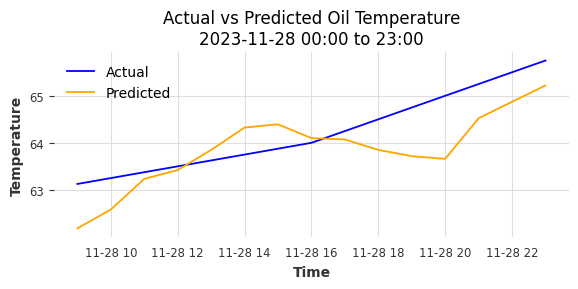

In [3]:
import pandas as pd
from darts import TimeSeries
from darts.models import TransformerModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt

# 1. خواندن داده
df = pd.read_excel("main_trans.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])

# 2. فیلتر بازه زمانی
target_date = pd.to_datetime('2023-9-01 00:00:00')
df_filtered = df[df['DateTime'] >= target_date]

# 3. بازنمونه‌گیری و پر کردن داده‌های خالی
df_filtered = df_filtered.set_index('DateTime').resample('1H').mean()
df_filtered = df_filtered.interpolate(method='linear')

# 4. ساخت سری هدف و covariates
series = TimeSeries.from_dataframe(df_filtered, value_cols='oil temperature', freq='h')
covariates = TimeSeries.from_dataframe(df_filtered, value_cols=['winding temperature', 'tap position'], freq='h')

# 5. نرمال‌سازی
scaler_series = Scaler(MinMaxScaler())
series_scaled = scaler_series.fit_transform(series)

scaler_cov = Scaler(MinMaxScaler())
covariates_scaled = scaler_cov.fit_transform(covariates)

# 6. تقسیم داده‌ها
train_ratio = 0.95
train_series, test_series = series_scaled.split_after(train_ratio)
train_cov, test_cov = covariates_scaled.split_after(train_ratio)

# 7. ساخت مدل Transformer
model = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=12,
    n_epochs=100,
    model_name="oil-temp",
    nr_epochs_val_period=1,
    batch_size=32,
    d_model=64,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dropout=0.15,
    random_state=42
)

# 8. آموزش مدل
model.fit(series=train_series, past_covariates=train_cov, verbose=True)

# 9. پیش‌بینی
pred = model.predict(n=len(test_series), series=train_series, past_covariates=covariates_scaled)

# 10. بازگرداندن مقیاس اصلی
pred = scaler_series.inverse_transform(pred)
test_series = scaler_series.inverse_transform(test_series)

# 11. ارزیابی
print(f"RMSE: {rmse(test_series, pred):.2f}")
print(f"MAE: {mae(test_series, pred):.2f}")

# 12. تبدیل به DataFrame برای رسم
df_test = pd.DataFrame({'oil temperature': test_series.values().flatten()}, index=test_series.time_index)
df_pred = pd.DataFrame({'oil temperature': pred.values().flatten()}, index=pred.time_index)

# 13. رسم فقط یک روز از داده‌های تست و پیش‌بینی
start_time = df_test.index[0].replace(hour=0, minute=0, second=0)
end_time = start_time + pd.Timedelta(hours=23)

df_test_day = df_test[(df_test.index >= start_time) & (df_test.index <= end_time)]
df_pred_day = df_pred[(df_pred.index >= start_time) & (df_pred.index <= end_time)]

plt.figure(figsize=(6, 3))
plt.plot(df_test_day.index, df_test_day['oil temperature'], label='Actual', color='blue')
plt.plot(df_pred_day.index, df_pred_day['oil temperature'], label='Predicted', color='orange')
plt.legend()
plt.title(f"Actual vs Predicted Oil Temperature\n{start_time.date()} 00:00 to 23:00")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# !pip install darts

/tmp/ipython-input-2967559631.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_filtered = df_filtered.set_index('DateTime').resample('1H').mean()
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | c

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE: 1.68
MAE: 1.30


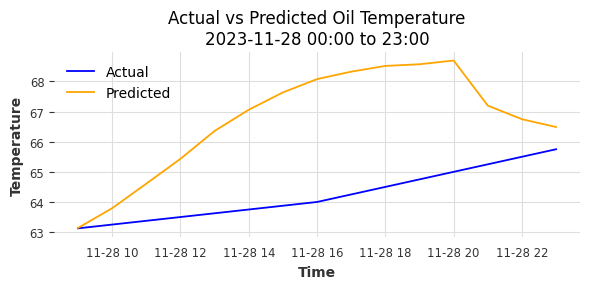

In [5]:
import pandas as pd
from darts import TimeSeries
from darts.models import TransformerModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt

# 1. خواندن داده
df = pd.read_excel("main_trans.xlsx")
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])

# 2. فیلتر بازه زمانی
target_date = pd.to_datetime('2023-9-01 00:00:00')
df_filtered = df[df['DateTime'] >= target_date]

# 3. بازنمونه‌گیری و پر کردن داده‌های خالی
df_filtered = df_filtered.set_index('DateTime').resample('1H').mean()
df_filtered = df_filtered.interpolate(method='linear')

# 4. ساخت سری هدف
series = TimeSeries.from_dataframe(df_filtered, value_cols='oil temperature', freq='h')

# 5. نرمال‌سازی
scaler_series = Scaler(MinMaxScaler())
series_scaled = scaler_series.fit_transform(series)

# 6. تقسیم داده‌ها
train_ratio = 0.95
train_series, test_series = series_scaled.split_after(train_ratio)

# 7. ساخت مدل Transformer بدون covariates
model = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=12,
    n_epochs=100,
    model_name="oil-temp",
    nr_epochs_val_period=1,
    batch_size=32,
    d_model=64,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dropout=0.15,
    random_state=42
)

# 8. آموزش مدل
model.fit(series=train_series, verbose=True)

# 9. پیش‌بینی
pred = model.predict(n=len(test_series), series=train_series)

# 10. بازگرداندن مقیاس اصلی
pred = scaler_series.inverse_transform(pred)
test_series = scaler_series.inverse_transform(test_series)

# 11. ارزیابی
print(f"RMSE: {rmse(test_series, pred):.2f}")
print(f"MAE: {mae(test_series, pred):.2f}")

# 12. تبدیل به DataFrame برای رسم
df_test = pd.DataFrame({'oil temperature': test_series.values().flatten()}, index=test_series.time_index)
df_pred = pd.DataFrame({'oil temperature': pred.values().flatten()}, index=pred.time_index)

# 13. رسم فقط یک روز از داده‌های تست و پیش‌بینی
start_time = df_test.index[0].replace(hour=0, minute=0, second=0)
end_time = start_time + pd.Timedelta(hours=23)

df_test_day = df_test[(df_test.index >= start_time) & (df_test.index <= end_time)]
df_pred_day = df_pred[(df_pred.index >= start_time) & (df_pred.index <= end_time)]

plt.figure(figsize=(6, 3))
plt.plot(df_test_day.index, df_test_day['oil temperature'], label='Actual', color='blue')
plt.plot(df_pred_day.index, df_pred_day['oil temperature'], label='Predicted', color='orange')
plt.legend()
plt.title(f"Actual vs Predicted Oil Temperature\n{start_time.date()} 00:00 to 23:00")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()
